### This script is based on simple features derived from text variables. 

In [223]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB

### load data

In [224]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [225]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 108129 rows and 14 columns
The test data has 63465 rows and 12 columns


In [254]:
train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status,name_len,name_count,desc_len,desc_count,keywords_len,keywords_count
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,0,20,USD,Sun May 3 02:59:59 2009,Sun May 3 03:00:17 2009,Fri Apr 24 15:15:07 2009,Fri Apr 24 15:52:03 2009,3,1,19,3,134,26,19,3
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,0,20,USD,Fri May 15 19:10:00 2009,Fri May 15 20:00:18 2009,Tue Apr 28 19:10:24 2009,Tue Apr 28 23:26:32 2009,2,0,76,10,137,25,74,10
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,0,20,USD,Fri May 22 17:26:00 2009,Fri May 22 17:30:18 2009,Tue May 12 17:26:53 2009,Tue May 12 17:39:58 2009,0,0,13,2,385,22,12,2
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,0,20,USD,Thu May 28 20:09:00 2009,Thu May 28 20:15:21 2009,Tue Apr 28 20:09:55 2009,Tue Apr 28 20:58:50 2009,18,1,30,6,131,23,29,6
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,0,20,USD,Sun May 31 07:38:00 2009,Sun May 31 07:45:17 2009,Fri May 1 07:38:34 2009,Fri May 1 08:22:21 2009,1,0,38,6,384,18,38,6


### convert time to unix format

In [226]:
import time

unix_cols = ['deadline','state_changed_at','launched_at','created_at']

for x in unix_cols:
    train[x] = train[x].apply(lambda k: time.ctime(k))
    test[x] = test[x].apply(lambda k: time.ctime(k))

### create simple features

In [227]:
cols_to_use = ['name','desc']
len_feats = ['name_len','desc_len']
count_feats = ['name_count','desc_count']

for i in np.arange(2):
    train[len_feats[i]] = train[cols_to_use[i]].apply(str).apply(len)
    train[count_feats[i]] = train[cols_to_use[i]].apply(str).apply(lambda x: len(x.split(' ')))

In [228]:
train['keywords_len'] = train['keywords'].apply(str).apply(len)
train['keywords_count'] = train['keywords'].apply(str).apply(lambda x: len(x.split('-')))

In [229]:
for i in np.arange(2):
    test[len_feats[i]] = test[cols_to_use[i]].apply(str).apply(len)
    test[count_feats[i]] = test[cols_to_use[i]].apply(str).apply(lambda x: len(x.split(' ')))
    
test['keywords_len'] = test['keywords'].apply(str).apply(len)
test['keywords_count'] = test['keywords'].apply(str).apply(lambda x: len(x.split('-')))

### encoding features

In [230]:
from sklearn.preprocessing import LabelEncoder

feat = ['disable_communication','country']
for x in feat:
    le = LabelEncoder()
    le.fit(list(train[x].values) + list(test[x].values))
    train[x] = le.transform(list(train[x]))
    test[x] = le.transform(list(test[x].values))
    

### model training

In [231]:
cols_to_use = ['name_len'
                 ,'desc_len'
                 ,'keywords_len'
                 ,'name_count'
                 ,'desc_count'
                 ,'keywords_count']

target = train['final_status']

# data for modeling
k_train = train[cols_to_use]
k_test = test[cols_to_use]

### naive bayes

In [232]:
gnb = GaussianNB()

nvb_pred = gnb.fit(k_train, target).predict(k_test)

In [233]:
gb = GradientBoostingClassifier()

gb.fit(k_train, target)

gb_pred = gb.predict(k_test)

In [234]:
# Voting classifier
vc = VotingClassifier(estimators=[
    ('XGB 200', xgb.XGBClassifier(n_estimators=200)),
    ('XGB 200', xgb.XGBClassifier(n_estimators=300, max_depth=4)),
    ('XGB 200', xgb.XGBClassifier(n_estimators=300, max_depth=7)),
    #('Dtree', DecisionTreeClassifier()),
    #('LD', LinearDiscriminantAnalysis()),
    ('Logistic Reg', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
])

vc.fit(k_train, target)

vc_pred = vc.predict(k_test)

# logistic regression
lreg.fit(k_train, target)

lreg_pred = lreg.predict(k_test)

In [235]:
train_cp = k_train.copy()
test_cp = k_test.copy()

In [236]:
train_cp['pred_1'] = gb.predict(k_train)
test_cp['pred_1'] =  gb_pred

train_cp['pred_2'] = vc.predict(k_train)
test_cp['pred_2'] =  vc_pred

train_cp['pred_3'] = lreg.predict(k_train)
test_cp['pred_3'] =  lreg_pred

In [239]:
train_cp.shape

(108129, 9)

In [238]:
test_cp.shape

(63465, 9)

### Stacking

In [240]:
gb_st = GradientBoostingClassifier()

gb_st.fit(train_cp, target)

gb_pred2 = gb_st.predict(test_cp)

### write the file

In [242]:
nBsub = pd.DataFrame({'project_id':test['project_id'],'final_status':gb_pred2})
nBsub = nBsub[['project_id','final_status']]
nBsub.to_csv("../output/stack_starter.csv",index = False)

# XGBboost

In [144]:
import xgboost as xgb

In [171]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=50, num_rounds=50):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.01
    param['max_depth'] = 4
    #param['silent'] = 1
    #param['eval_metric'] = "accuracy"
    param['min_child_weight'] = 1
    param['subsample'] = 0.9
    param['colsample_bytree'] = 0.9
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    return pred_test_y, model

In [172]:
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import accuracy_score, log_loss

train_X = k_train.values
train_y = target.values

cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-error:0.317989	test-error:0.325904
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 20 rounds.
[1]	train-error:0.318047	test-error:0.32595
[2]	train-error:0.318047	test-error:0.32595
[3]	train-error:0.318047	test-error:0.32595
[4]	train-error:0.318047	test-error:0.32595
[5]	train-error:0.318047	test-error:0.32595
[6]	train-error:0.318047	test-error:0.32595
[7]	train-error:0.318047	test-error:0.32595
[8]	train-error:0.318047	test-error:0.32595
[9]	train-error:0.318047	test-error:0.32595
[10]	train-error:0.318047	test-error:0.32595
[11]	train-error:0.318047	test-error:0.32595
[12]	train-error:0.318047	test-error:0.32595
[13]	train-error:0.318047	test-error:0.32595
[14]	train-error:0.318047	test-error:0.32595
[15]	train-error:0.318047	test-error:0.32595
[16]	train-error:0.318047	test-error:0.32595
[17]	train-error:0.318047	test-error:0.32595
[18]	train-error:0.318047	test-error:0.32595
[19]	trai

# Multiple Classifiers Showdown

In [151]:
from sklearn.cross_validation import StratifiedShuffleSplit

In [153]:
labels = target.values
train = k_train.values

sss = StratifiedShuffleSplit(labels, 10, test_size=0.2, random_state=23)

for train_index, test_index in sss:
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [157]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# SVC(kernel="rbf", C=0.025, probability=True),
#     NuSVC(probability=True),

vc = VotingClassifier(estimators=[
    ('GBM', GradientBoostingClassifier()),
    ('XGB 200', xgb.XGBClassifier(n_estimators=200)),
    ('Dtree', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('LD', LinearDiscriminantAnalysis()),
    ('QD', QuadraticDiscriminantAnalysis()),
    ('Logistic Reg', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('GNB', GaussianNB())
]
, voting='soft')

classifiers = [
    vc,
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier(n_estimators=100),
    xgb.XGBClassifier(n_estimators=20, max_depth=4, colsample_bytree=0.9, subsample=0.9, learning_rate=0.01),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

VotingClassifier
****Results****
Accuracy: 67.2478%
Log Loss: 0.6287727864632118
LogisticRegression
****Results****
Accuracy: 68.0385%
Log Loss: 0.6241566037366627
KNeighborsClassifier
****Results****
Accuracy: 60.3764%
Log Loss: 4.563287552426007
DecisionTreeClassifier
****Results****
Accuracy: 58.1199%
Log Loss: 13.582102419603162
RandomForestClassifier
****Results****
Accuracy: 61.9902%
Log Loss: 1.9093889049989083
AdaBoostClassifier
****Results****
Accuracy: 68.0338%
Log Loss: 0.6901507674224574
GradientBoostingClassifier
****Results****
Accuracy: 68.0292%
Log Loss: 0.6178136694694528
XGBClassifier
****Results****
Accuracy: 68.0385%
Log Loss: 0.6177700232532852
XGBClassifier
****Results****
Accuracy: 68.0385%
Log Loss: 0.6701551839374409
GaussianNB
****Results****
Accuracy: 66.4478%
Log Loss: 0.642799076935415
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.0385%
Log Loss: 0.6241741595377777
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 67.2200%
Log Loss: 0.629657

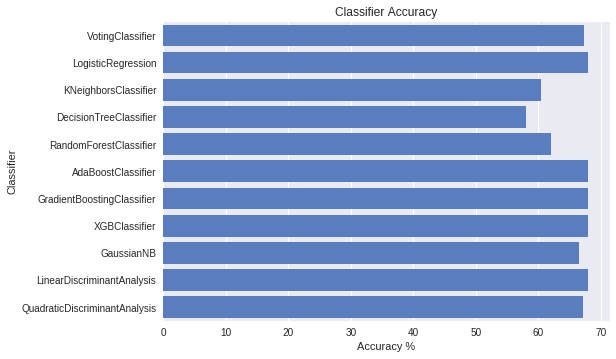

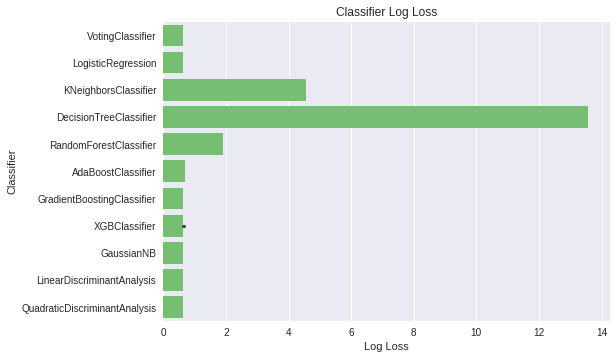

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# Cross Validation

In [243]:
clf = DecisionTreeClassifier()


rf = RandomForestClassifier()

knn = KNeighborsClassifier()

lreg = LogisticRegression()

vc = VotingClassifier(estimators=[
    ('XGB 200', xgb.XGBClassifier(n_estimators=200)),
    ('XGB 200', xgb.XGBClassifier(n_estimators=300, max_depth=4)),
    ('XGB 200', xgb.XGBClassifier(n_estimators=300, max_depth=7)),
    #('Dtree', DecisionTreeClassifier()),
    #('LD', LinearDiscriminantAnalysis()),
    ('Logistic Reg', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
])

In [246]:
from sklearn.model_selection import cross_val_score

In [250]:
gbm = GradientBoostingClassifier(n_estimators=250, max_depth=4, learning_rate=0.01, subsample=0.9, )

In [251]:
scores = cross_val_score(gbm, train_X, train_y, scoring='accuracy', cv=5)

In [252]:
scores.mean()

0.68037251814133237